In [17]:
import heapq
import random
from PIL import Image
import numpy
import nltk
from IPython.display import display, Image as Img

# Minimum Spanning Trees:
This tutorial will teach you the basics of Minimum spanning trees, Algorithms on how to make them, and some applications of minimum spanning trees.  

# Task Zero: Graph Representations
For this part, we need to decide on a graph representation that we will use for the rest of the problems in this task.  
For implementing Minimum spanning trees, it is useful to represent graphs as a list of vertices (from 0 to n-1), and a list of edges in the form (u, v, c).  As you will soon see, most of our algorithms involve sorting edges and finding connected components, which we can do quickly via these representations.  

There are many other representation that are more suited to different algorithms, for example if we were trying to compute a search algorithm, it would be very convienient to represents graphs as a dictionary of outgoing edges, since we only care about the local neighborhood of any given vertex, rather than the position of every edge relative to the other edges.  In paticular, we notice that for running prim's algorithms, it is really uncomfortable to use our graph representation, so our Prim's algorithm does not run in the advertised time.  

Note: we will only use directed graphs for this tutorial, but you can make them directed by duplicating every edge and reversing the direction (which we will often do anyways).  

# Task One: The Basics
We will first cover two sequential algorithms for finding minimum spanning trees.  These are both sequential, and you can verify that they take O(mlogm) work and O(m) span, where m is the number of edges.  
1) Prim's Algorithm: First discovered in 1930 by Vojtech Jarnik, the algorithm goes as follows:

    a) pick one vertex to visit first, in our case, we'll just pick vertex 0.  
    
    b) find the lightest outgoing edge from the set of visited vertices, if it leads to a new edge, then add the edge to the edges in the MST, and add the vertex to the visited vertices, otherwise pick the next lightest edge until a suitable one is found
    
    c) Repeat step 2 until all vertices are visited, or we have completed a component.  We can repeat this for every component, but for now we'll just assume that our graph is connected.  
    
2) Kruskals Algorithm: First appearing in 1956, written by Joseph Kruskal, the algorithm goes as follows:

    a) Create a list of all edges in the graph, and initialize a forrest of individual vertices.  
    
    b) Add the minimum weight edges to the MST Edges if and only if it doesn't form a cycle.  The vertex must connect two forrests, so combine/contract the two forrests into one. (*)
    
    c) Repeat the algorithm until there is only one connected component, or no edges remain.
    
Aside: A good way to perform contraction is to have representatives for each vertex.  When we want to contract an edge, we pick one of the vertices to be the representative of the other, and to find the top, we follow the chain up until one vertex is its own representative.  This takes O(n) to find the the component a vertex is in, worst case.  

In [18]:
def outgoing(vertex, edges):
    return map(lambda (x, y, c) : (c, (x, y)), filter(lambda (x, y, c) : x == vertex, edges))

def find_set(components, x):
    if(components[x] == x):
        return x
    else:
        return find_set(components, components[x])

def prims(graph):
    visited = [graph[0][0]]
    edges = []
    heap = outgoing(visited[0], graph[1])
    heapq.heapify(map(lambda x : reversed(x), heap))
    while(visited != graph[0]):
        (c, (x, y)) = heapq.heappop(heap)
        if(y in visited):
            continue
        else:
            edges += [(x, y, c)]
            visited += [y]
            for (c, (a, b)) in outgoing(y, graph[1]):
                heapq.heappush(heap, (c, (a, b)))
    return edges

def kruskals(graph):
    edges = list(reversed(sorted(graph[1], key=lambda x : x[2])))
    components = sorted(graph[0])
    numcomponents = len(graph[0])
    mstedges = []
    while(numcomponents != 1 and edges != []):
        (x, y, c) = edges.pop()
        if(find_set(components, x) == find_set(components, y)):
            continue
        else:
            components[y] = x
            mstedges += [(x, y, c)]
            numcomponents = numcomponents - 1
    return mstedges

# Task Two: Parallelism to the Rescue
The previous algorithms were nice, but seemed awkward to implement with our graph representation.  Now we will see how we can parallelize the process.

Definition: We define the cut_G(S) = {(u, v) in E | u in S and v in V\S}

Lemma (Light edge property): Assume that G has unique edge weights.  For all S subset E, if we define x to be the minimum weight edge in cut_G(S), then x is in the MST Edges.  

Proof: Let T be the MST of G, and fix a cut S, and let x be the minimum edge in the cut.  If x is in T, then we are done. 
Otherwise assume for contradiction that x is not in the cut.  Since T is an MST, S and V\S must be in the same connected component with respect to T, so there must be another edge, y, in the cut that is in T.  Since our edge weights are unique, the weight of x must be strictly less than the weight of y.  Consider the tree formed by removing y and connecting S and V\S with x, this tree must be of less weight than T, which contradicts the fact that T was the MST.  
Therefore x must be in the MST for any set S.  

Equipped with this knowledge, we realize that by defining S = {v}, we can find an edge in the MST for every vertex in the graph, and this motivates some parallel algorithms...

# Boruvka's Algorithm
Published in 1926 by Otakar Boruvka, the algorithm goes as follows:
1) Initialize a forrest where each tree is a single vertex

2) While the forrest has more than one connected component:  
    a) For each component, add the cheapest outgoing edge to the potential MST edges.  Since the cut {v} and V/{v} is valid, the lightest of the edges spanning this cut (ie outing edges of v) must be in the MST.  
    b) Contract along the potential MST edges, add the edges to the MST.  

3) Repeat step 2 (called the Boruvka step) until there is only one connected component, which means we have found the minimum spanning tree.

# Contraction
Part of Boruvka's algorithm is contracting the edges to make a new edgeset.  Before, when we contracted only one edge at a time, this was easy, but now we may need to contract multiple edges into a single vertex.  There are many ways to do this, but in this example we will use Star Contraction.  

1) Label vertices as stars or satellites by flipping a coin n times

2) For every edge (u, v), if u is a satellite and v is a star, then contract u into v.  We represent the contraction by setting the representative of u as v, and replacing u by v in all of the edges.  (and then removing all edges going from v -> v).  Our contraction function just returns the representatives, BoruvkaStep takes care of pruning the edges.  

At every round of Boruvka's algorithm we do this, and you can verify that we expect to get O(n) many edges that need to be contracted, and at 1/4 of them will be contracted in expectation, which means we expect O(logn) many rounds to occur, each taking O(m) time.  So the work of Boruvka's is O(mlogn).  

In [19]:
# Requires: E is the edge set, reverse sorted by weights (so low weights appear at the end of the list)
# Returns: Minimum edge comming out of each vertex in range(n)
def minEdges(E, n):
    minE = [(-1, -1, (-1, -1, -1)) for i in range(n)]
    for (u, v, w, l) in E:
        minE[u] = (v, w, l)
    return minE
# To do star contraction, we first decide which ones are stars and which are sattelites.
# If v is a head, then we contract u to v (and add it to the mst), otherwise we leave u alone.
def findSatellites((u, (v, w, l)), flips):
    if(v == -1):
        return (u, -1, -1, (-1, -1, -1))
    else:
        if(flips[u] == 0 and flips[v] == 1):
            return (u, v, w, l)
        else:
            return (u, -1, -1, (-1, -1, -1))
# First we flip heads, and then get the minimum outgoing edge of each of the vertices
# Then we run star contraction on it to get the components, as well as mst edges
def starContract(E, n):
    flips = [random.randint(0, 1) for i in range(n)]
    minE = minEdges(E, n)
    contracted = map(lambda x : findSatellites(x, flips), enumerate(minE))
    return contracted

In [20]:
def BoruvkaStep(labeled, T, n):
    # Get the components of the new graph
    contract = starContract(labeled, n)
    # Find the representatives (if we contracted the edge, then v will not be -1, so u will be contracted into v, otherwise u stays as u)
    reps = map(lambda (u, v, w, l) : u if v == -1 else v, contract)
    # Now we remove the edges that were invalid to get the mst edges
    contract = filter(lambda (u, v, w, l) : v != -1, contract)
    # l represents the original edge, so we add it to the mst
    T = T + [l for (u, v, w, l) in contract]
    # Now we apply the contraction and filter out any edges that were destroyed as a result.  
    labeled = filter(lambda (u, v, w, l) : reps[u] != reps[v], labeled)
    labeled = map (lambda (u, v, w, l) : (reps[u], reps[v], w, l), labeled)
    return labeled, T

def Boruvka(graph):
    n = len(graph[0])
    sort = (sorted(graph[1], lambda x, y : -x[2] + y[2]))
    # We want to contract, so we need to carry the original list with us
    labeled = map(lambda (u, v, w) : (u, v, w, (u, v, w)), sort)
    # Initialize a new MST
    T = []
    while(len(labeled) != 0):
        labeled, T = BoruvkaStep(labeled, T, n)
    return T

In [21]:
## Here is a small example to make sure that the code works.
V = range(4)
E = [(0, 1, 4), (1, 0, 4), (1, 2, 3), (2, 1, 3), (2, 3, 4), (3, 2, 4), (0, 2, 7), (2, 0, 7)]
print(Boruvka((V, E)))
print(prims((V, E)))
print(kruskals((V, E)))
# We can verify that all 3 algorithms agree on the MST for this small case, which means we didn't do anything too wrong.

[(0, 1, 4), (2, 1, 3), (3, 2, 4)]
[(0, 1, 4), (1, 2, 3), (2, 3, 4)]
[(1, 2, 3), (0, 1, 4), (2, 3, 4)]


# Task Three: Randomize
Now that we have the Boruvka step, we can actually one up boruvka's algorithm by doing work in between rounds of Boruvka Steps.  
In paticular we define F-heavy edges in the following manner: Let F be a Minimum spanning forrest of a graph G, then an edge (u,v, c) in E is a F-heavy edge if c is greater than the heaviest edge in the path connecting u and v in F.  (if no path connects u and v in F, then (u, v, c) is not F-heavy).  

We claim that for any minimum spanning forrest F, all of the F-heavy edges in G are not in the MST, and we can compute them in linear time (with respect to the number of edges in the graph).  One way we can do this is by running kruskal's algorithm, traversing the edges in order of weight.  When we run kruskals and encounter an edge that would make a cycle, we can remove it since it is larger than the heaviest edge currently in the mst connecting it's endpoints.  

So, here's the algorithm: 

1) Run some fixed number of boruvka steps to get some preliminary mst edges.  
2) After that, create a new graph by including edges in G with one half probability, which we will call F.  
3) Find the F-heavy edges of G by running modified kruskals algorithm.  
4) Remove the F-heavy edges we found, and do it again until we are done finding the MST.  

If it is done right, this will solve the MST problem in expected time O(m), and worst case time O(mlogn), the same bound as Boruvka's algorithm.  

In [1]:
# As we describe above, what findheavy needs to do is run kruskals algorithm 
# and remove any cycle edges, as they can't be F-light.
def findheavy(graph, edges):
    edges = sorted(edges, lambda x : x[2])
    components = sorted(graph[1])
    numcomponents = len(graph[0])
    mstedges = []
    fheavy = []
    while(numcomponents != 1 or edges != []):
        (x, y, c, l) = edges.pop()
        if(find_set(components, x) == find_set(components, y)):
            fheavy += [(x, y, c, l)]
            continue
        else:
            if((x, y, c, l) not in graph[1]):
                continue
            components[y] = x
            mstedges += [(x, y)]
            numcomponents = numcomponents - 1
    return fheavy, mstedges

def Tarjan(graph):
    n = len(graph[0])
    sort = (sorted(graph[1], lambda x, y : -x[2] + y[2]))
    # We want to contract, so we need to carry the original list with us
    labeled = map(lambda (u, v, w) : (u, v, w, (u, v, w)), sort)
    # Initialize a new MST
    T = []
    while(len(labeled) != 0):
        labeled, T = BoruvkaStep(labeled, T, n)
        labeled, T = BoruvkaStep(labeled, T, n)
        flips = [random.randint(0, 1) for i in range(len(labeled))]
        # There's Some False Advertising here, as this could be done much faster by removing edges from E as we find them.  
        # We also note that the theoretical bound of O(m) is very difficult to achieve without using Fibbonacci heaps or Brodal set,
        # neither of which are fun to implement or quick
        newE = [x for x in labeled if flips[x] == 1]
        fheavy, msf = findheavy(graph[0], newE, labeled)
        labeled = filter(lambda x : x not in fheavy, labeled)
    return T

# Task Four: Applications
Now we will look at some uses of minimum spanning tree.  In paticular we will look at creating a dependency tree from a sentence, and performing clustering with a modified boruvka's algorithm.  

# Dependency Parsers

Following the outline set in http://www.seas.upenn.edu/~strctlrn/bib/PDF/nonprojectiveHLT-EMNLP2005.pdf, we can use Maximum spanning trees (which we can get by negating a graph and computing it's Minimum spanning tree), to determine dependencies among words in a sentence (assuming we can extract features from the sentence).  We won't go into detail about what kinds of features are best to use, but we will use some cursory features to get a feel for how the algorithm works.  

Features for this parser can get very complex (http://ufal.mff.cuni.cz/~zabokrtsky/publications/papers/featureengin07.pdf), and often require machine learning to determine weighting, but we will use the following as features with some made up weightings:

1) The direction of the dependency (-1 or 1 depending on which of the two words appears first in the sentence).  

2) The POS tags of the dependency

3) Distance between two words

The basic idea of the algorithm is that if we have a metric between words that represents how dependent words are, we can find a maximum spanning tree of the dense graph, and this will find us the subtree that has the highest dependency.  Of course, finding the best way to determine dependency is really difficult.  

There isn't enough room in this tutorial for me to explain how to perform the machine learning to determine the proper correlation weighting for two words in a sentence, but I highly recommend reading the papers above to learn more about how it was really done.  

In [2]:
# These are fake functions to give you a sense of what this would do
def tagscore(tag1, tag2):
    if(tag1 == "NN" and tag2 == "NN"):
        return 1
    else:
        return 2
    
def f(distance, direction, POSs):
    return distance + direction + POSs

def extractGraph(sentence):
    edges = []
    for i in range(len(sentence)):
        for j in range(len(sentence)):
            if(i == j):
                continue
            else:
                distance = abs(i-j)
                direction = 1 if i < j else -1
                POSs = tagscore(sentence[i][1], sentence[j][1])
            edges += (i, j, -f(distance, direction, POSs))
    return edges

# This will work, but not as well as we expect it to do.  To really do it, read the papers listed above.  
def parsedep(sentence):
    G = (range(len(sentence.split(" "))), extractGraph(nltk.pos_tag(sentence.split(" "))))
    edges = Boruvka(G)
    return map(lambda (x, y, c) : (sentence.split(" ")[x], sentence.split(" ")[y]), edges)

In [80]:
# Here is a sentence that we can parse, and below it is the answer as provided by the Stanford parser
parsedep("Bills on ports and immigration were submitted by Republican Senator Brownback of Kansas")

[('submitted', 'Bills'),
 ('Bills', 'on'),
 ('on', 'ports'),
 ('ports', 'and'),
 ('ports', 'immigration'),
 ('submitted', 'were'),
 ('submitted', 'by'),
 ('by', 'Brownback'),
 ('Brownback', 'Senator'),
 ('Brownback', 'Republican'),
 ('Republican', 'of'),
 ('of', 'Kansas')]

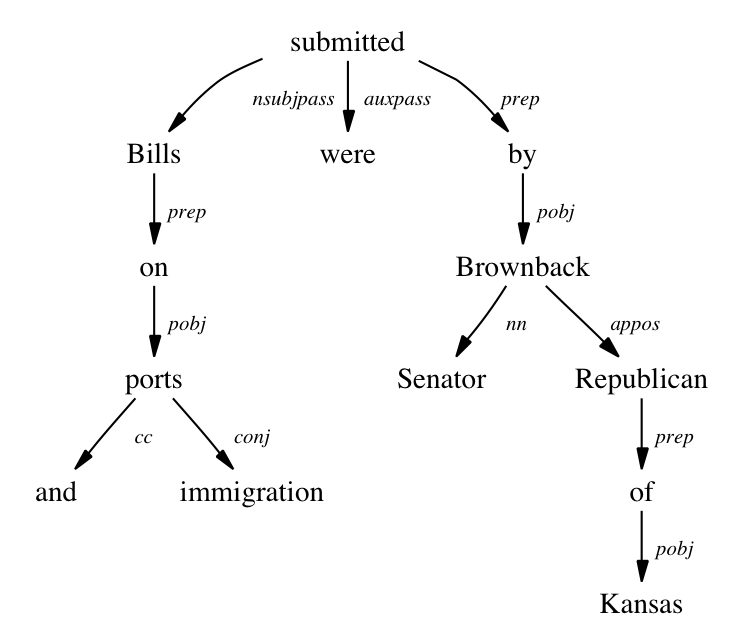

In [81]:
Img(filename='deptree.png')

# Cluster Detection and Image Segmentation

Now, we will modify our implementation of Boruvka's to make it find a minimum spanning forrest, removing key edges from the original graph if they are too "difficult" to contract.  

In paticular we will make it cost "currency" to contract edges, and when two edges try to contract, we subtract the weight of the edge from the minimum credits of the two contracted vertices.  At the beginning of every round we filter out any edges that can not be contracted because of our cost requirement.  We continue this until there are no contractable edges or we are finished contracting, and unlike the previous MST algorithms, here we are interested in the connected components of the MSF rather than the edges, as these represent the clusters in the data.  

We notice that rather than making a minimum spanning tree, this will create a forrest, and each forrest will be determined by some notion of proximity of vertices in the components.  For a picture, we determine the proximity by the absolute difference in the colors of the two, so that similar colors will get merged more often than different colors.  For clustering, we could define it to be any metric we want, the L2 norm, or manhattan distance.  

The function below will look really similar to Boruvka's algorithm, with some new credit variables.  

In [22]:
 def Segment(graph, initialcredits):
        # The first part is copying over your code from boruvka's
        n = len(graph[0])
        credits = [initialcredits for i in range(n)]
        sort = sorted(graph[1], lambda x, y : int(-x[2] + y[2]))
        # We are going to record the connect components of the graph the same way as before.  
        colors = range(n)
        # We want to contract, so we need to carry the original list with us
        labeled = map(lambda (u, v, w) : (u, v, w, (u, v, w)), sort)
        # Initialize a new MST
        T = []
        # We will repeat the body of the loop until there are not more edges to run on
        while(len(labeled) != 0):
            # First filter out the edges that can't be contracted along
            labeled = filter(lambda (u, v, w, l) : min(credits[u], credits[v]) > w, labeled)
            # Get the components of the new graph
            contract = starContract(labeled, n)
            
            # Find the representatives (if we contracted the edge, then v will not be -1, so u will be contracted into v, otherwise u stays as u)
            reps = map(lambda (u, v, w, l) : u if v == -1 else v, contract)
            for i in range(n):
                if(contract[i][1] != -1):
                    colors[contract[i][0]] = contract[i][1]
            
            # Now we remove the edges that were invalid to get the mst edges
            contract = filter(lambda (u, v, w, l) : v != -1, contract)
            
            # l represents the original edge, so we add it to the mst
            T = T + [l for (u, v, w, l) in contract]
            
            # Now we apply the contraction and filter out any edges that were destroyed as a result.  
            labeled = filter(lambda (u, v, w, l) : reps[u] != reps[v], labeled)
            labeled = map (lambda (u, v, w, l) : (reps[u], reps[v], w, l), labeled)
            
            ## I might consider making this a seperate chunk, but the logic is very simple, and 
            ## I don't see a reason to modularize this part.  
            contractedcredit = map(lambda (u, v, w, l) : (v, credits[u]), contract)
            creditdict = dict()
            for (u, c) in contractedcredit:
                if(u in creditdict):
                    creditdict[u] += [c]
                else:
                    creditdict[u] = [c]
            def findMin(v, dic):
                return (v, reduce(lambda x, y : min(x, y), dic[v]))
            for i in creditdict:
                creditdict[i] = (findMin(i, creditdict))
            weights = map(lambda (u, v, w, l) : (v, w), contract)
            weightdict = dict()
            for (u, w) in weightdict:
                if(u in weightdict):
                    weightdict[u] += [w]
                else:
                    weightdict[u] = [w]
            for i in weightdict:
                weightdict[i] = (reduce(lambda x, y : x+y, (i, weightdict)))
            for i in weightdict:
                credits[i] = creditdict[i]-weightdict[i]
        return (T, colors)

The function below is just a helper function that creates all of our edges from the picture array by taking every pair of adjacent vertices and weighting the edge as the magnitude of the distance vector between their colors.  It's long because there are a lot of edge cases and I wanted to make sure that I was transparent with my algorithms.

In [23]:
def process(filename):
    img = numpy.asarray(Image.open(filename))
    edges = []
    vertices = []
    for i in range(len(img)):
        for j in range(len(img[0])):
            vertices += [i + j*len(img)]
            if(i == 0):
                if(j == 0):
                    edges += [(i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
                elif(j == len(img[0]) - 1):
                    edges += [(i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1]))]
                else:
                    edges += [(i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
            elif(i == len(img) - 1):
                if(j == 0):
                    edges += [(i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
                elif(j == len(img[0])-1):
                    edges += [(i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1]))]
                else:
                    edges += [(i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
            elif(j == 0):
                edges += [(i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
            elif(j == len(img[0])-1):
                edges += [(i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1]))]
            else:
                edges += [(i + j*len(img), i + j*len(img) - 1, abs(img[i][j] - img[i-1][j])), (i + j*len(img), i + j*len(img) + 1, abs(img[i][j] - img[i+1][j])), (i + j*len(img), i + (j-1)*len(img), abs(img[i][j] - img[i][j-1])), (i + j*len(img), i + (j+1)*len(img), abs(img[i][j] - img[i][j+1]))]
    return (sorted(vertices), map(lambda (a, b, w) : (a, b, numpy.linalg.norm(w)), edges))
                

Below is a little example of how to run the program, incase you wanted to try it out.  Basically we find the MST components and turn each pixel's color into it's representatives color.  (This takes a few seconds to run).

In [24]:
(V, E) = process("sunset.jpg")
MST, Components = Segment((V, E), 10)
newpic = numpy.zeros(numpy.asarray(Image.open("sunset.jpg")).shape, dtype = numpy.uint8)
oldpic = numpy.asarray(Image.open('sunset.jpg'))
(x, y, z) = newpic.shape
for i in V:
    component = find_set(Components, i)
    color = numpy.asarray(Image.open("sunset.jpg"))[component%x, (int(component/x))]
    newpic[i%x, (int(i/x))] = color

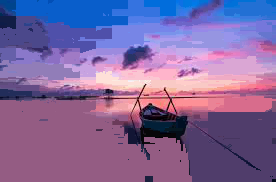

In [25]:
image = Image.fromarray(newpic, 'RGB')
image.save("sunset-10.png")
Img(filename = 'sunset-10.png')

Below are some more pretty pictures, observe what happens when we increase the initial credits given to each vertex.

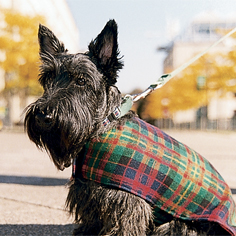

In [74]:
Img(filename='dog.png')

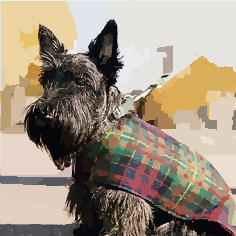

In [75]:
Img(filename='dog-1000.png')

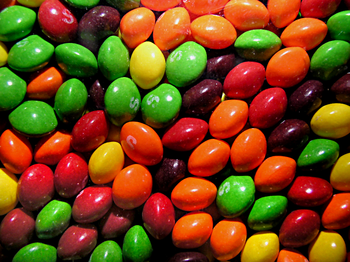

In [7]:
Img(filename='skittles.png')

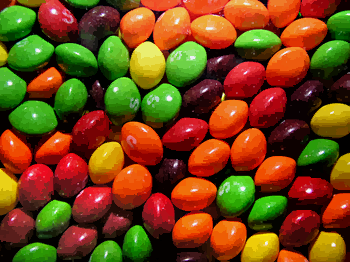

In [5]:
Img(filename='skittles-100.png')

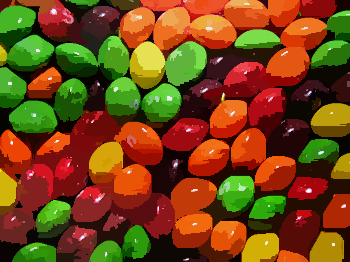

In [6]:
Img(filename='skittles-1000.png')